In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#read data from parquet file
#number of days from the beginning of the year to consider in the analysis
periodo = 365
USE_CUMSUM = True

common_filter = """
FROM datos_urgencia_consolidados.parquet
--where IdCausa in (7)
--where IdCausa in (2) 
--where IdCausa in (10) 
where IdCausa in (3,4,5,6,10,11)
and CodigoRegion is not null
--and GLOSATIPOESTABLECIMIENTO = 'Hospital'
--and CodigoRegion = 13
and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
--and year(strptime(fecha, '%d/%m/%Y')) in (2022,2023)
--group by CodigoRegion, dayofyear(strptime(fecha, '%d/%m/%Y'))
--group by CodigoRegion, fecha
group by CodigoDependencia, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'Menores_1' as grupo_etario
    , sum(Menores_1) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    ,'De_1_a_4' as grupo_etario
    , sum(De_1_a_4) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_5_a_14' as grupo_etario
    , sum(De_5_a_14) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_15_a_64'  as grupo_etario
    , sum(De_15_a_64) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_65_y_mas' as grupo_etario
    , sum(De_65_y_mas) as atenciones
"""+ common_filter + """
""").df()

df2 = df2.sort_values(by=['year','CodigoRegion','grupo_etario','nrodia']).reset_index(drop = True)

In [4]:
#the cumulative sum is taken on each of the classes, 
#is this case we group by "year", "CodigoRegion" and "grupo_etario"
#the result is a dataframe with the "nro_dia" in the columns, 
#in which the cumulative information of the demand, scaled from 0 to 1 is stored
groups = df2[["year","CodigoRegion","grupo_etario"]].drop_duplicates()
df_aux =df2.copy()
for (index, year, region, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoRegion'] == region) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if USE_CUMSUM:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / max(df_aux.loc[indicesToKeep, 'atenciones'])
        else:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / sum(df_aux.loc[indicesToKeep, 'atenciones'])
df3 = df_aux.pivot(index=['year','CodigoRegion','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separating out the features
x_original = df3.loc[:, [k+1 for k in range(periodo)]].values

# Separating out the target
y = df3.loc[:,['CodigoRegion','grupo_etario']].values

#Standardizing the features
scaler = StandardScaler().fit(x_original)
x = scaler.transform(x_original)

pca = PCA(n_components=4)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4'])
finalDf = pd.concat([principalDf, df3[['CodigoRegion','grupo_etario']]], axis = 1)

targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]



Percentange of the variance explained by each principal component


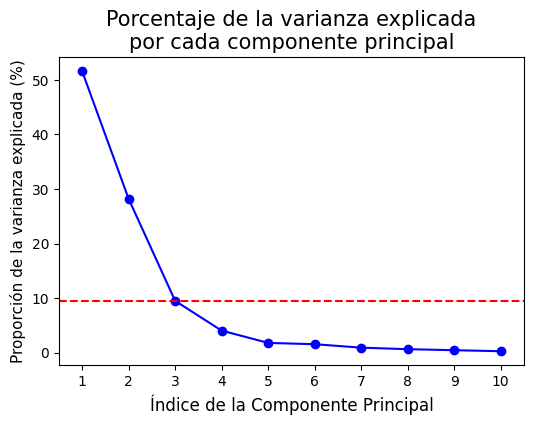

In [6]:
#
#Short report of the performance of the PCA analysis
print("Percentange of the variance explained by each principal component")

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
#principalDf = pd.DataFrame(data = principalComponents
#             , columns = ['PC1', 'PC2', 'PC3','PC4'])
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1) 
plt.plot([k+1 for k in range(pca.n_components_)],100*pca.explained_variance_ratio_,'-bo')
plt.axhline(y = 100*pca.explained_variance_ratio_[2] , color='r', linestyle='dashed')

ax.set_title('Porcentaje de la varianza explicada\npor cada componente principal', fontsize = 15)
ax.set_xlabel('Índice de la Componente Principal', fontsize = 12)
ax.set_ylabel('Proporción de la varianza explicada (%)', fontsize = 11)
ax.set_xlim(xmin=0.5)
ax.set_xlim(xmax=10.5)
plt.xticks([k+1 for k in range(pca.n_components_)])
#print(pca.explained_variance_ratio_)
#print(pca.explained_variance_ratio_.cumsum())
plt.savefig('fig6_varianza_explicada.png', bbox_inches='tight')

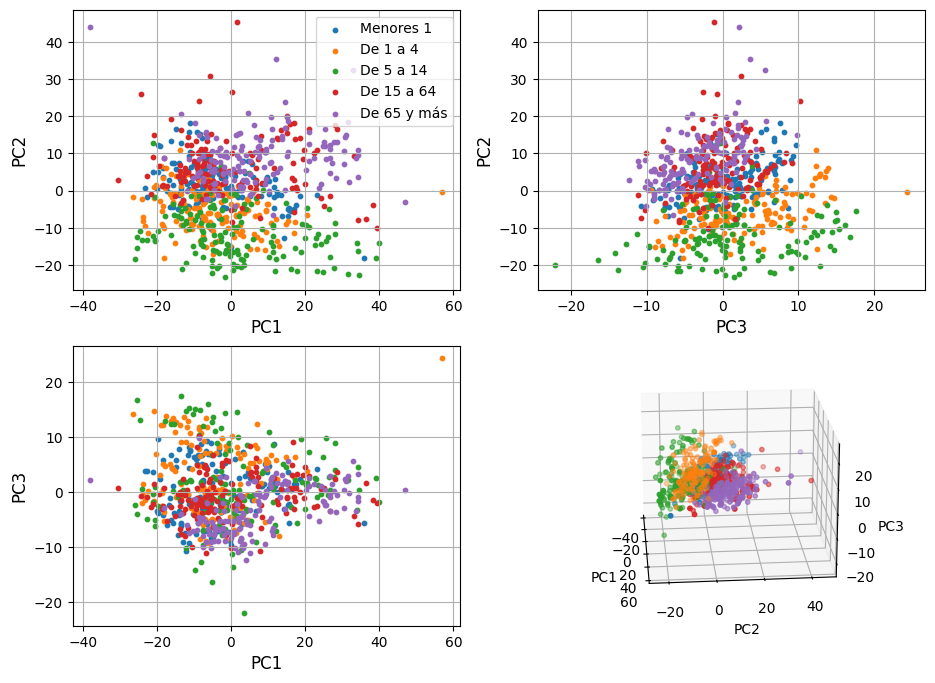

In [7]:
#Figura 7: componentes principales correspondientes a la separacion por año, servicio de salud y grupo etario
fig = plt.figure(figsize = (11,8))
ax = fig.add_subplot(2,2,1) 
#ax.set_title('2 component PCA', fontsize = 20)
#ax.set_title('PC1 vs PC2', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
#for target, color in zip(targets,colors):
for target in targets:
    indicesToKeep = finalDf['grupo_etario'] == target
    #indicesToKeep = finalDf['CodigoRegion'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
#               , c = color
               , s = 10)
ax.grid()

targets_legends = ["Menores 1","De 1 a 4","De 5 a 14","De 15 a 64","De 65 y más"]
ax.legend(targets_legends)
    
ax = fig.add_subplot(2,2,2) 
#ax.set_title('PC1 vs PC3', fontsize = 15)
ax.set_xlabel('PC3', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in targets:
    indicesToKeep = finalDf['grupo_etario'] == target
    #indicesToKeep = finalDf['CodigoRegion'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC3']
               , finalDf.loc[indicesToKeep, 'PC2']
#               , c = color
               , s = 10)
ax.grid()
    
ax = fig.add_subplot(2,2,3) 
#ax.set_title('PC2 vs PC3', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC3', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in targets:
    indicesToKeep = finalDf['grupo_etario'] == target
    #indicesToKeep = finalDf['CodigoRegion'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC3']
#               , c = color
               , s = 10)
ax.grid()

#ax.legend(targets)
#ax.grid()

#3D PLot of the principal componentes
#fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(2,2,4,projection='3d')

targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
#colors = ['r', 'g', 'b','orange', 'pink']
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in targets:
    indicesToKeep = finalDf['grupo_etario'] == target
    #indicesToKeep = finalDf['CodigoRegion'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , finalDf.loc[indicesToKeep, 'PC3']
#               , c = color
               , s = 10)
ax.elev = 20
ax.azim = -5 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#ax.legend(targets)
plt.savefig('fig7_pca_todos.png', bbox_inches='tight')

#plt.show()

In [8]:
# #Plot of the Principal components without rescaling
# plt.plot([k for k in range(periodo)],pca.components_[0,:],color='r')
# plt.plot([k for k in range(periodo)],pca.components_[1,:],color='orange')
# plt.grid()

# #scaler.inverse_transform(principalComponents[:,1].reshape(1, -1))
# x_original = df3.loc[:, [k+1 for k in range(periodo)]].values
# scaler = StandardScaler().fit(x_original)
# z = scaler.transform(x_original)
# plt.figure()
# if USE_CUMSUM:
#     scalingFactor = 20
# else:
#     scalingFactor = 4
# plt.plot([k for k in range(periodo)],scaler.inverse_transform(scalingFactor*pca.components_)[0,:],color='r')
# plt.plot([k for k in range(periodo)],scaler.inverse_transform(scalingFactor*pca.components_)[1,:],color='orange')
# #plt.plot([k for k in range(periodo)],scaler.inverse_transform(50*pca.components_)[2,:],color='g')
# #plt.plot([k for k in range(periodo)],scaler.inverse_transform(50*pca.components_)[3,:],color='b')
# plt.plot([k for k in range(periodo)],scaler.inverse_transform(0*pca.components_)[0,:],color='gray', linestyle='dashed')
# plt.figure()
# plt.plot([k for k in range(periodo)],x_original[3,:])
# plt.plot([k for k in range(periodo)],x_original[50,:])
# plt.plot([k for k in range(periodo)],x_original[70,:])
# plt.plot([k for k in range(periodo)],scaler.inverse_transform(0*pca.components_)[0,:],color='gray', linestyle='dashed')